<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/Multivariate_Random_Forest_for_bridging_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multivariate Random Forest

https://github.com/souhirbenamor/Electricity_Price_Forecating/blob/main/Collected%20codes/ARIMA%2BMultivariate%20RF%2B%20Multivariate%20LSTM%2B%20Naive%20model%2B%20Python/Random_Forest%20(1).ipynb


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor



from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import GRU

import numpy as np

In [7]:
df = pd.read_excel('/content/electricty_real&Funda_data.xlsx')
df.drop(df.loc[df['Date'].duplicated()].index, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# df = df.sort_values(df['datetime'], ascending=[True])
df.set_index(df['Date'], inplace = True)
df.drop(columns = [ 'Date'], inplace = True)
df

,price day ahead real,Estimated price,Lignite,Natural Gas,Hard Coal,Nuclear,Demand DE,Wind,PV,Gas,Coal,CO2
Date,,,,,,,,,,,,
2014-12-31 23:59:59.991,18.29,25.390297,389.000000,234.685058,188.576064,0.0,40242.25,8280.00,0.0,21.30,55.17,7.27
2015-01-01 00:59:59.991,16.04,24.980000,389.000000,234.685058,188.576064,0.0,39158.50,8412.75,0.0,21.30,55.17,7.27
2015-01-01 01:59:59.991,14.60,24.796874,389.000000,234.685058,188.576064,0.0,38824.50,8502.25,0.0,21.30,55.17,7.27
2015-01-01 02:59:59.991,14.95,26.074430,389.000000,234.685058,188.576064,0.0,38969.25,8668.50,0.0,21.30,55.17,7.27
2015-01-01 03:59:59.991,14.50,20.377994,389.000000,234.685058,188.576064,0.0,39092.75,8849.25,0.0,21.30,55.17,7.27
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 18:59:59.980,56.70,56.545811,4052.024327,3981.697440,5449.000000,0.0,49516.00,8053.50,0.0,19.12,56.49,32.59
2020-12-31 19:59:59.980,52.44,50.781170,4052.024327,3981.697440,5449.000000,0.0,47747.50,7456.50,0.0,19.12,56.49,32.59
2020-12-31 20:59:59.980,51.86,50.781170,4052.024327,3981.697440,5449.000000,0.0,47761.75,6902.50,0.0,19.12,56.49,32.59


In [8]:
def table2lags(table, max_lag, min_lag=0, separator='_'):
    """ Given a dataframe, return a dataframe with different lags of all its columns """
    values=[]
    for i in range(min_lag, max_lag + 1):
        values.append(table.shift(i).copy())
        values[-1].columns = [c + separator + str(i) for c in table.columns]
    return pd.concat(values, axis=1)

In [9]:
df.head()

,price day ahead real,Estimated price,Lignite,Natural Gas,Hard Coal,Nuclear,Demand DE,Wind,PV,Gas,Coal,CO2
Date,,,,,,,,,,,,
2014-12-31 23:59:59.991,18.29,25.390297,389.0,234.685058,188.576064,0.0,40242.25,8280.00,0.0,21.3,55.17,7.27
2015-01-01 00:59:59.991,16.04,24.980000,389.0,234.685058,188.576064,0.0,39158.50,8412.75,0.0,21.3,55.17,7.27
2015-01-01 01:59:59.991,14.60,24.796874,389.0,234.685058,188.576064,0.0,38824.50,8502.25,0.0,21.3,55.17,7.27
2015-01-01 02:59:59.991,14.95,26.074430,389.0,234.685058,188.576064,0.0,38969.25,8668.50,0.0,21.3,55.17,7.27
2015-01-01 03:59:59.991,14.50,20.377994,389.0,234.685058,188.576064,0.0,39092.75,8849.25,0.0,21.3,55.17,7.27


In [10]:
df_lagged = table2lags(df, 168, 24)

In [11]:
df_lagged.columns

Index(['price day ahead real_24', 'Estimated price _24', 'Lignite_24',
       'Natural Gas_24', 'Hard Coal_24', 'Nuclear_24', 'Demand DE_24',
       'Wind_24', 'PV_24', 'Gas_24',
       ...
       'Lignite_168', 'Natural Gas_168', 'Hard Coal_168', 'Nuclear_168',
       'Demand DE_168', 'Wind_168', 'PV_168', 'Gas_168', 'Coal_168',
       'CO2_168'],
      dtype='object', length=1740)

In [12]:
df_lagged.shape

(52608, 1740)

In [13]:
x_train = df_lagged[168:25000]
x_valid = df_lagged[25000:34968]
x_test = df_lagged[34968:]

In [14]:
x_test

,price day ahead real_24,Estimated price _24,Lignite_24,Natural Gas_24,Hard Coal_24,Nuclear_24,Demand DE_24,Wind_24,PV_24,Gas_24,...,Lignite_168,Natural Gas_168,Hard Coal_168,Nuclear_168,Demand DE_168,Wind_168,PV_168,Gas_168,Coal_168,CO2_168
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-27 23:59:59.983,47.10,39.219525,5523.000000,4970.493057,9206.463483,445.965882,39897.296574,14644.75,0.0,23.32,...,2398.000000,4610.493057,5196.463483,445.965882,51721.905191,23734.50,0.0,24.90,76.81,24.65
2018-12-28 00:59:59.983,46.74,36.613695,5523.000000,4970.493057,9206.463483,445.965882,39159.097927,14584.00,0.0,23.32,...,2298.000000,4610.493057,5196.463483,445.965882,50793.975590,23836.00,0.0,24.90,76.81,24.65
2018-12-28 01:59:59.983,45.03,36.613695,5523.000000,4970.493057,9206.463483,445.965882,39347.674404,14483.50,0.0,23.32,...,2398.000000,4610.493057,5196.463483,445.965882,50977.661236,23716.75,0.0,24.90,76.81,24.65
2018-12-28 02:59:59.983,46.02,36.613695,5523.000000,4970.493057,9206.463483,445.965882,40655.714942,14317.00,0.0,23.32,...,2298.000000,4610.493057,5196.463483,445.965882,52288.667476,23570.25,0.0,24.90,76.81,24.65
2018-12-28 03:59:59.983,49.18,39.219525,5386.000000,4970.493057,9932.463483,445.965882,43192.763039,14007.50,0.0,23.32,...,2298.000000,5036.493057,5196.463483,445.965882,55380.341428,23201.50,0.0,24.90,76.81,24.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 18:59:59.980,52.38,57.232450,5839.024327,3471.697440,5910.000000,0.000000,56966.960478,20328.00,0.0,19.00,...,3138.024327,3728.697440,5100.000000,0.000000,51942.250000,20864.00,0.0,17.65,54.25,32.06
2020-12-31 19:59:59.980,46.88,51.475727,5839.024327,3471.697440,5910.000000,0.000000,54256.048861,20341.50,0.0,19.00,...,3138.024327,3728.697440,5100.000000,0.000000,50449.750000,20602.75,0.0,17.65,54.25,32.06
2020-12-31 20:59:59.980,43.22,49.856000,5839.024327,4185.697440,5910.000000,0.000000,52265.530407,20285.75,0.0,19.00,...,3138.024327,3728.697440,5100.000000,0.000000,49465.000000,20197.50,0.0,17.65,54.25,32.06


In [15]:
y_train = df['price day ahead real'][168:25000]
y_valid = df['price day ahead real'][25000:34968]
y_test = df['price day ahead real'][34968:]

In [16]:
y_test

Date
2018-12-27 23:59:59.983    50.00
2018-12-28 00:59:59.983    49.19
2018-12-28 01:59:59.983    48.51
2018-12-28 02:59:59.983    48.07
2018-12-28 03:59:59.983    49.82
                           ...  
2020-12-31 18:59:59.980    56.70
2020-12-31 19:59:59.980    52.44
2020-12-31 20:59:59.980    51.86
2020-12-31 21:59:59.980    52.26
2020-12-31 22:59:59.980    50.87
Name: price day ahead real, Length: 17640, dtype: float64

In [17]:
x_test.head()

,price day ahead real_24,Estimated price _24,Lignite_24,Natural Gas_24,Hard Coal_24,Nuclear_24,Demand DE_24,Wind_24,PV_24,Gas_24,...,Lignite_168,Natural Gas_168,Hard Coal_168,Nuclear_168,Demand DE_168,Wind_168,PV_168,Gas_168,Coal_168,CO2_168
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-27 23:59:59.983,47.10,39.219525,5523.0,4970.493057,9206.463483,445.965882,39897.296574,14644.75,0.0,23.32,...,2398.0,4610.493057,5196.463483,445.965882,51721.905191,23734.50,0.0,24.9,76.81,24.65
2018-12-28 00:59:59.983,46.74,36.613695,5523.0,4970.493057,9206.463483,445.965882,39159.097927,14584.00,0.0,23.32,...,2298.0,4610.493057,5196.463483,445.965882,50793.975590,23836.00,0.0,24.9,76.81,24.65
2018-12-28 01:59:59.983,45.03,36.613695,5523.0,4970.493057,9206.463483,445.965882,39347.674404,14483.50,0.0,23.32,...,2398.0,4610.493057,5196.463483,445.965882,50977.661236,23716.75,0.0,24.9,76.81,24.65
2018-12-28 02:59:59.983,46.02,36.613695,5523.0,4970.493057,9206.463483,445.965882,40655.714942,14317.00,0.0,23.32,...,2298.0,4610.493057,5196.463483,445.965882,52288.667476,23570.25,0.0,24.9,76.81,24.65
2018-12-28 03:59:59.983,49.18,39.219525,5386.0,4970.493057,9932.463483,445.965882,43192.763039,14007.50,0.0,23.32,...,2298.0,5036.493057,5196.463483,445.965882,55380.341428,23201.50,0.0,24.9,76.81,24.65


In [18]:
rf = RandomForestRegressor(n_estimators=10, max_features=2,
    criterion='mae',
    max_depth=1)

    
rf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mae', max_depth=1, max_features=2,
                      n_estimators=10)

In [19]:
y_test = pd.DataFrame(y_test)

In [20]:
y_pred = rf.predict(x_test)

In [21]:
y_test['predictions'] = y_pred

In [22]:
y_test['difference'] = np.abs(y_test['price day ahead real'] - y_test['predictions'])
y_test['% error'] = (y_test['difference']/y_test['price day ahead real'])*100
np.mean(y_test['% error'])

inf

In [23]:
y_test['% error'] = (y_test['difference']/y_test['price day ahead real'])*100

In [24]:
y_test

,price day ahead real,predictions,difference,% error
Date,,,,
2018-12-27 23:59:59.983,50.00,31.8265,18.1735,36.347000
2018-12-28 00:59:59.983,49.19,31.2915,17.8985,36.386461
2018-12-28 01:59:59.983,48.51,31.2915,17.2185,35.494743
2018-12-28 02:59:59.983,48.07,31.2915,16.7785,34.904306
2018-12-28 03:59:59.983,49.82,31.2915,18.5285,37.190887
...,...,...,...,...
2020-12-31 18:59:59.980,56.70,31.6455,25.0545,44.187831
2020-12-31 19:59:59.980,52.44,31.6455,20.7945,39.653890
2020-12-31 20:59:59.980,51.86,31.6455,20.2145,38.978982


In [25]:
#np.mean(y_test['% error'])

In [ ]:
#y_test.drop(y_test.loc[y_test['% error'] > 2000].index, inplace = True)

In [ ]:
#np.mean(np.abs(y_test['price day ahead real'] - y_test['predictions']) * 100)

1159.4893582243553

In [26]:
y_test

,price day ahead real,predictions,difference,% error
Date,,,,
2018-12-27 23:59:59.983,50.00,31.8265,18.1735,36.347000
2018-12-28 00:59:59.983,49.19,31.2915,17.8985,36.386461
2018-12-28 01:59:59.983,48.51,31.2915,17.2185,35.494743
2018-12-28 02:59:59.983,48.07,31.2915,16.7785,34.904306
2018-12-28 03:59:59.983,49.82,31.2915,18.5285,37.190887
...,...,...,...,...
2020-12-31 18:59:59.980,56.70,31.6455,25.0545,44.187831
2020-12-31 19:59:59.980,52.44,31.6455,20.7945,39.653890
2020-12-31 20:59:59.980,51.86,31.6455,20.2145,38.978982


In [27]:
#save prediction results
y_test.to_excel("Random_forest_results.xlsx", header=True)

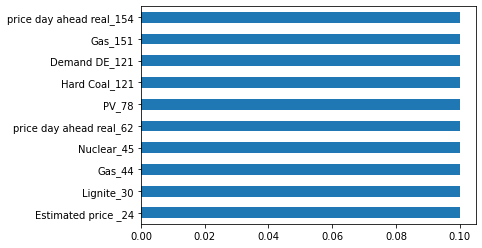

In [28]:
feat_importances = pd.Series(rf.feature_importances_, index=df_lagged.columns)
feat_importances.nlargest(10).plot(kind='barh')

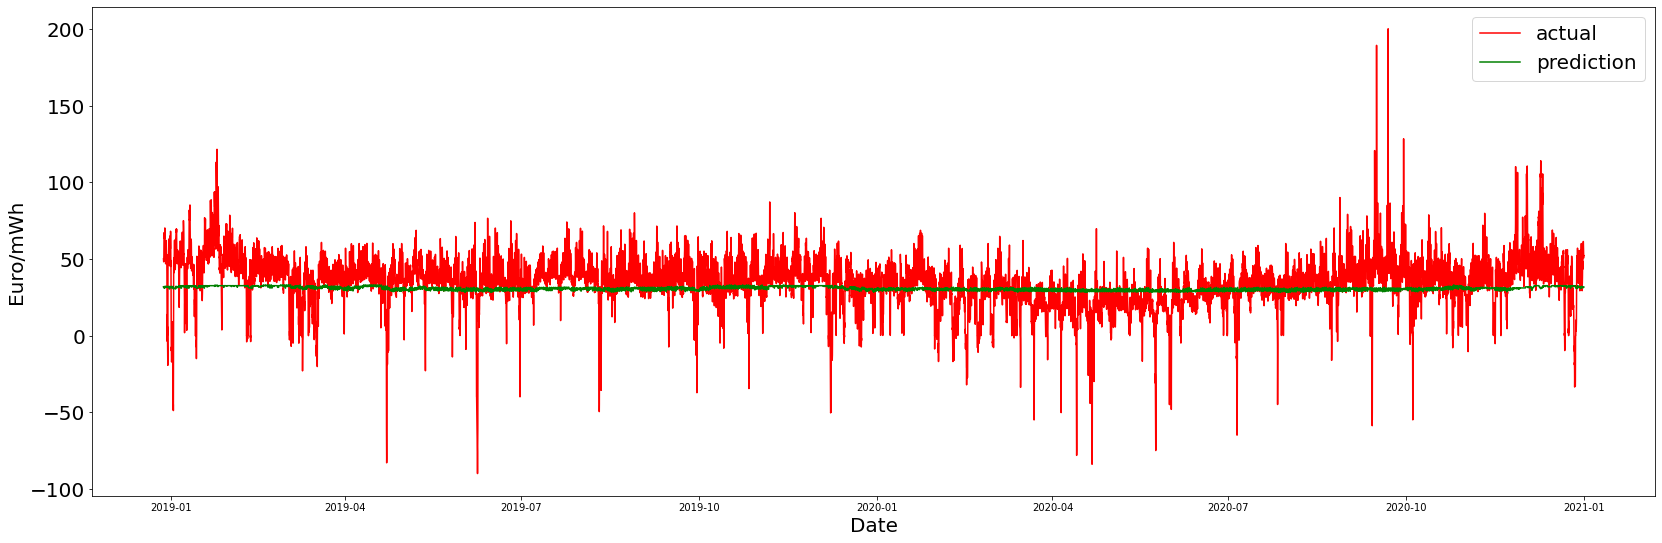

In [31]:
fig, ax = plt.subplots(figsize = (28,9))
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Euro/mWh', fontsize=20)
ax.plot(y_test['price day ahead real'] , label = 'actual', color = 'r')
ax.plot(y_test['predictions'], label = 'prediction', color = 'g')
ax.tick_params(axis='y', labelsize = 20)
ax.legend(prop={'size': 20}) 

In [32]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
gridsearch = {'bootstrap': [True],
     'max_depth': [10, 250],
     'min_samples_leaf': [2, 5],
     'n_estimators': [100, 200]}
# print(gridsearch)
# {'bootstrap': [True],
#  'max_depth': [10, 50, 250,1000],
#  'max_features': [2, 'sqrt'],
#  'min_samples_leaf': [1, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 1000, 2000]}

In [33]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_GridSearch = GridSearchCV(
 estimator = rf, 
 param_grid = gridsearch, 
 cv = 2,
 verbose=2, 
 n_jobs = 1)

In [ ]:
rf_GridSearch.fit(x_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=17.9min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=16.3min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200; total time=35.8min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200; total time=32.3min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, n_estimators=100; total time=17.7min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, n_estimators=100; total time=15.9min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, n_estimators=200; total time=35.4min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, n_estimators=200; total time=31.8min
[CV] END bootstrap=True, max_depth=250, min_samples_leaf=2, n_estimators=100; total time=31.6min
[CV] END bootstrap=True, max_depth=250, min_samples_leaf=2, n_estimators=10

In [ ]:
print(rf_GridSearch.best_score_)
print(rf_GridSearch.best_params_)

0.4772704634297745
{'bootstrap': True, 'max_depth': 250, 'min_samples_leaf': 5, 'n_estimators': 100}


In [ ]:
rf = RandomForestRegressor(n_estimators=250, max_features=5,
    criterion='mae',
    max_depth=15)

    
rf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mae', max_depth=15, max_features=5,
                      n_estimators=250)

In [ ]:
prediciton = rf.predict(x_test)

In [ ]:
prediciton = pd.DataFrame(prediciton)

prediciton.to_csv('randomforestprediction.csv')

In [ ]:
prediciton.to_excel("Random_forest_GridSearch_results.xlsx", header=True)

In [ ]:
len(prediciton)

17640

In [ ]:
len(x_test)

17640

In [ ]:
x_test.isna().sum()

price day ahead real_24     0
Estimated price _24         0
price day ahead real_25     0
Estimated price _25         0
price day ahead real_26     0
                           ..
Estimated price _166        0
price day ahead real_167    0
Estimated price _167        0
price day ahead real_168    0
Estimated price _168        0
Length: 290, dtype: int64

In [ ]:
y_test

,price day ahead real,predictions,difference,% error
Date,,,,
2018-12-27 23:59:59.983,50.00,32.9140,17.0860,34.172000
2018-12-28 00:59:59.983,49.19,32.9140,16.2760,33.088026
2018-12-28 01:59:59.983,48.51,31.9710,16.5390,34.094001
2018-12-28 02:59:59.983,48.07,32.9830,15.0870,31.385480
2018-12-28 03:59:59.983,49.82,33.9260,15.8940,31.902850
...,...,...,...,...
2020-12-31 18:59:59.980,56.70,34.5725,22.1275,39.025573
2020-12-31 19:59:59.980,52.44,34.5725,17.8675,34.072273
2020-12-31 20:59:59.980,51.86,34.8230,17.0370,32.851909


In [ ]:
prediciton = y_test.iloc[:,:2]

In [ ]:
prediciton

,price day ahead real,predictions
Date,,
2018-12-27 23:59:59.983,50.00,32.9140
2018-12-28 00:59:59.983,49.19,32.9140
2018-12-28 01:59:59.983,48.51,31.9710
2018-12-28 02:59:59.983,48.07,32.9830
2018-12-28 03:59:59.983,49.82,33.9260
...,...,...
2020-12-31 18:59:59.980,56.70,34.5725
2020-12-31 19:59:59.980,52.44,34.5725
2020-12-31 20:59:59.980,51.86,34.8230


In [ ]:
prediciton.rename(columns = {0:'prediction'}, inplace = True)

In [ ]:
prediciton['difference'] = np.abs(prediciton['price day ahead real'] - prediciton['predictions'])
prediciton['% error'] = ((prediciton['difference'] + 0.5) /(prediciton['price day ahead real'] + 0.5))*100
# np.mean(prediciton['% error'])

In [ ]:
prediciton['% error'].mean()

109.93962814065479

In [ ]:
from numpy import inf

In [ ]:
prediciton.loc[prediciton['% error'] == 36798.27999999999]

,price day ahead real,predictions,difference,% error
Date,,,,


In [ ]:
mape = 100 * (prediciton['difference'] / prediciton['price day ahead real'])
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
100 - accuracy

329.4120081285097

In [ ]:
prediciton['% error'] = mape

In [ ]:
np.mean(mape[np.isfinite(mape)])

329.4120081285097

In [ ]:
mape

Date
2018-12-27 23:59:59.983    34.172000
2018-12-28 00:59:59.983    33.088026
2018-12-28 01:59:59.983    34.094001
2018-12-28 02:59:59.983    31.385480
2018-12-28 03:59:59.983    31.902850
                             ...    
2020-12-31 18:59:59.980    39.025573
2020-12-31 19:59:59.980    34.072273
2020-12-31 20:59:59.980    32.851909
2020-12-31 21:59:59.980    35.564485
2020-12-31 22:59:59.980    33.803814
Length: 17640, dtype: float64

In [ ]:
mape[np.isfinite(mape)].mean()

329.4120081285097

In [ ]:
# Save prediction as CSV
import pandas as pd
from pandas import read_csv
import csv
y_pred=prediciton
y_pred=pd.DataFrame(y_pred)
print(y_pred)
y_pred.to_csv("y_pred.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')

                         price day ahead real  predictions  difference  \
Date                                                                     
2018-12-27 23:59:59.983                 50.00      32.9140     17.0860   
2018-12-28 00:59:59.983                 49.19      32.9140     16.2760   
2018-12-28 01:59:59.983                 48.51      31.9710     16.5390   
2018-12-28 02:59:59.983                 48.07      32.9830     15.0870   
2018-12-28 03:59:59.983                 49.82      33.9260     15.8940   
...                                       ...          ...         ...   
2020-12-31 18:59:59.980                 56.70      34.5725     22.1275   
2020-12-31 19:59:59.980                 52.44      34.5725     17.8675   
2020-12-31 20:59:59.980                 51.86      34.8230     17.0370   
2020-12-31 21:59:59.980                 52.26      33.6740     18.5860   
2020-12-31 22:59:59.980                 50.87      33.6740     17.1960   

                           % error  


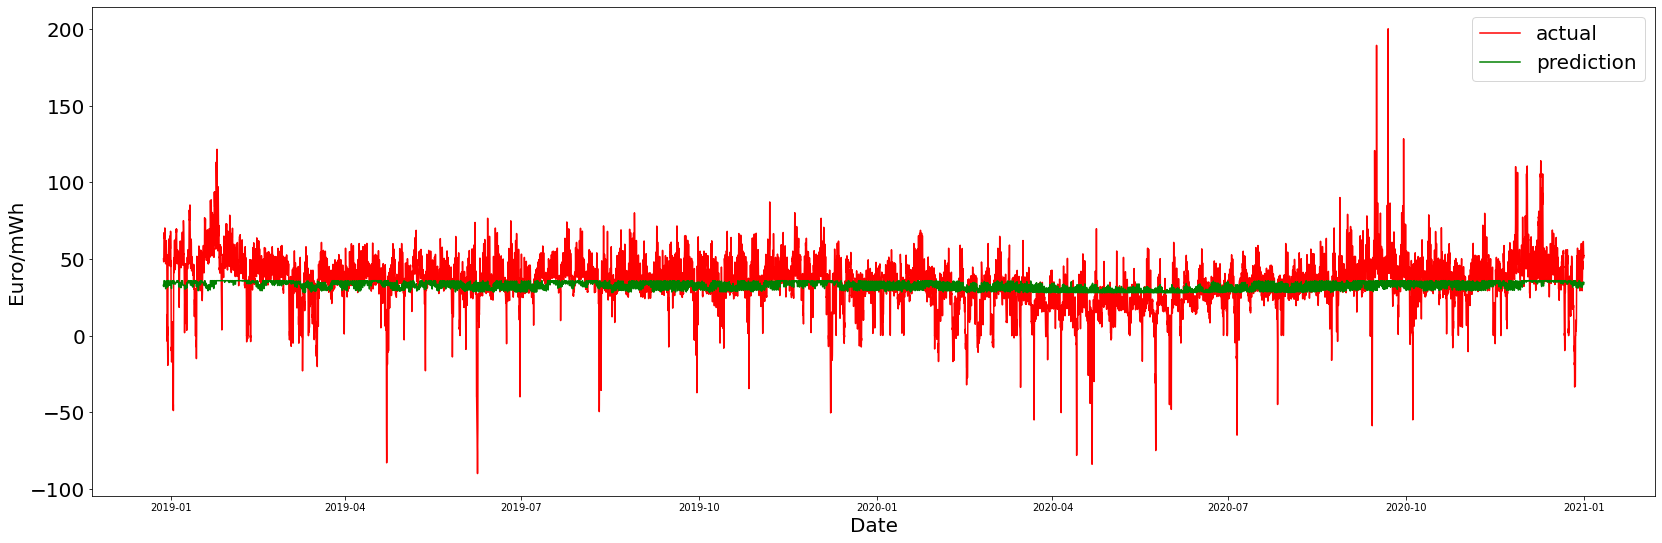

In [ ]:

fig, ax = plt.subplots(figsize = (28,9))
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Euro/mWh', fontsize=20)
ax.plot(prediciton['price day ahead real'] , label = 'actual', color = 'r')
ax.plot(prediciton['predictions'], label = 'prediction', color = 'g')
ax.tick_params(axis='y', labelsize = 20)
ax.legend(prop={'size': 20})